In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import librosa

# Define where the WAV files are
base_path = '/content/drive/MyDrive/recordings'

# Lists to store data
audio_signals = []
digit_labels = []

# Loop through all files in the base path
for filename in os.listdir(base_path):
    if filename.endswith('.wav'):
        file_path = os.path.join(base_path, filename)

        # Extract the digit label from the start of the filename
        try:
            label = int(filename[0])  # Assumes format like: 7_theo_32.wav
        except ValueError:
            continue  # Skip if filename doesn't start with a digit

        # Load the audio file
        y, sr = librosa.load(file_path, sr=None)

        # Store audio and label
        audio_signals.append(y)
        digit_labels.append(label)

print(f" Loaded {len(audio_signals)} WAV files")
print(f"First label: {digit_labels[0]}")
print(f"First signal length: {len(audio_signals[0])}")


 Loaded 3000 WAV files
First label: 6
First signal length: 3277


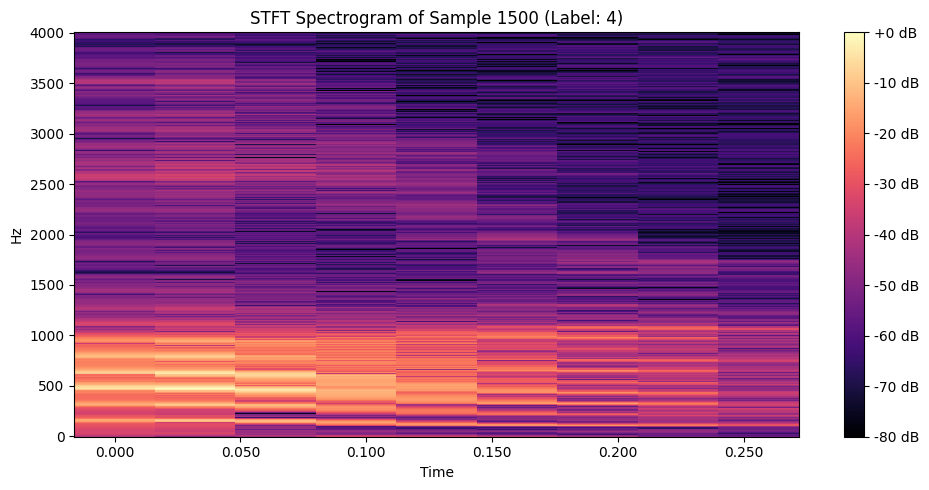

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Pick one sample to analyze
index = 1500  # change this to try other samples
y = audio_signals[index]
sr = 8000

# Apply STFT
n_fft = 1024           # FFT window size
hop_length = 256       # number of samples between successive frames
win_length = 1024      # same as n_fft here
window = 'hamming'

stft_result = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)

# Convert to magnitude (amplitude)
magnitude = np.abs(stft_result)

# Convert amplitude to decibels
db_spectrogram = librosa.amplitude_to_db(magnitude, ref=np.max)

# Plot STFT Spectrogram
plt.figure(figsize=(10, 5))
librosa.display.specshow(db_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(f'STFT Spectrogram of Sample {index} (Label: {digit_labels[index]})')
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import librosa

# STFT parameters
n_fft = 1024
hop_length = 256
win_length = 1024
window = 'hamming'

# List to store all spectrograms
spectrograms_db = []

for i, y in enumerate(audio_signals):
    # Compute STFT
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)

    # Convert to magnitude
    magnitude = np.abs(stft)

    # Convert to decibel scale
    db_spec = librosa.amplitude_to_db(magnitude, ref=np.max)

    # Store the result
    spectrograms_db.append(db_spec)

print(f" Computed STFT for {len(spectrograms_db)} samples.")
print("Example shape:", spectrograms_db[1500].shape)


 Computed STFT for 3000 samples.
Example shape: (513, 9)


In [6]:
fixed_frames = 128

final_specs = []

for spec in spectrograms_db:
    time_len = spec.shape[1]

    if time_len > fixed_frames:
        # Crop excess frames
        processed = spec[:, :fixed_frames]
    elif time_len < fixed_frames:
        # Pad with zeros at the end
        pad_width = fixed_frames - time_len
        processed = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        # Already perfect size
        processed = spec

    final_specs.append(processed)

# Convert to NumPy array for ML use
X = np.array(final_specs)  # Shape: (num_samples, freq_bins, fixed_frames)
y = np.array(digit_labels)

print(" Final dataset shape:", X.shape)


 Final dataset shape: (3000, 513, 128)


In [12]:
pip install openpyxl


In [15]:
import librosa
import numpy as np
import pandas as pd

# Sampling rate
sr = 8000

# Placeholder lists for each feature
centroids = []
bandwidths = []
rolloffs = []
flatnesses = []

# Loop over all spectrograms (STFTs)
for i, y in enumerate(audio_signals):
    # Compute STFT
    S = np.abs(librosa.stft(y, n_fft=1024, hop_length=256, win_length=1024, window='hann'))

    # Extract features
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85)
    flatness = librosa.feature.spectral_flatness(S=S)

    # Average over all time frames
    centroids.append(np.mean(centroid))
    bandwidths.append(np.mean(bandwidth))
    rolloffs.append(np.mean(rolloff))
    flatnesses.append(np.mean(flatness))

# Combine all features into one labeled DataFrame
df_features = pd.DataFrame({
    'Spectral_Centroid': centroids,
    'Spectral_Bandwidth': bandwidths,
    'Spectral_Rolloff': rolloffs,
    'Spectral_Flatness': flatnesses,
    'Label': digit_labels
})

# Display shape
print(" Feature matrix shape:", df_features.shape)

# Save to CSV
df_features.to_csv("labeled_spectral_features.csv", index=False)
print(" Labeled feature table saved as 'labeled_spectral_features.csv'")

# Save to Excel
df_features.to_excel("labeled_spectral_features.xlsx", index=False)
print(" Labeled feature table also saved as 'labeled_spectral_features.xlsx'")


 Feature matrix shape: (3000, 5)
 Labeled feature table saved as 'labeled_spectral_features.csv'
 Labeled feature table also saved as 'labeled_spectral_features.xlsx'


<ipython-input-8-cf9cb55c4f2c>:13: RuntimeWarning: divide by zero encountered in log10
  W_db = 20 * np.log10(W / np.max(W))


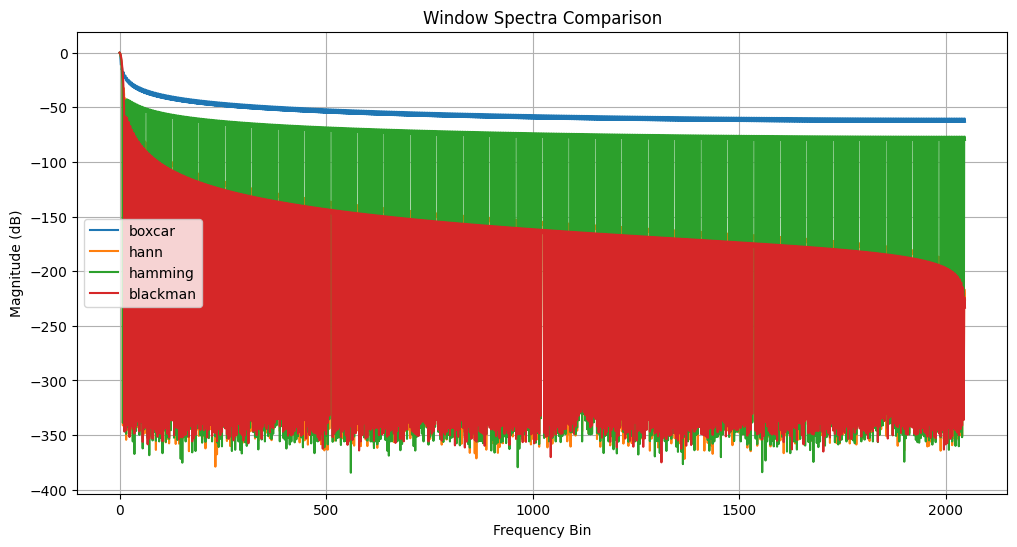

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window

# Compare common windows
window_types = ['boxcar', 'hann', 'hamming', 'blackman']
N = 1024

plt.figure(figsize=(12, 6))
for wtype in window_types:
    w = get_window(wtype, N)
    W = np.abs(np.fft.fft(w, 4096))[:2048]
    W_db = 20 * np.log10(W / np.max(W))
    plt.plot(W_db, label=wtype)

plt.title('Window Spectra Comparison')
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()


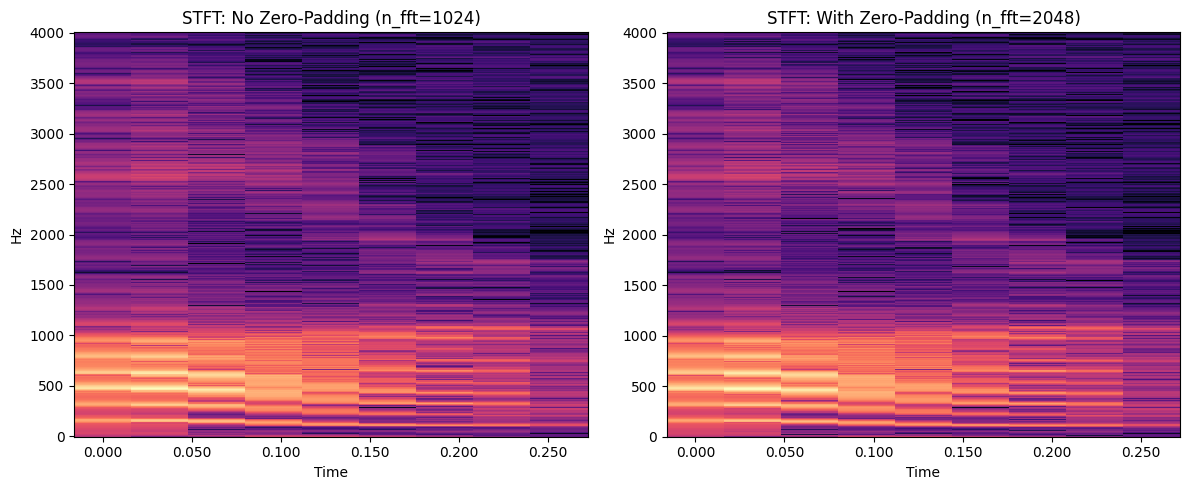

In [9]:
import librosa
import librosa.display

# Load a short signal
y = audio_signals[1500]
sr = 8000

# Apply STFT with and without zero-padding
stft_no_pad = librosa.stft(y, n_fft=1024, hop_length=256, win_length=1024)
stft_padded = librosa.stft(y, n_fft=2048, hop_length=256, win_length=1024)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_no_pad), ref=np.max),
                         sr=sr, hop_length=256, x_axis='time', y_axis='linear')
plt.title("STFT: No Zero-Padding (n_fft=1024)")

plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_padded), ref=np.max),
                         sr=sr, hop_length=256, x_axis='time', y_axis='linear')
plt.title("STFT: With Zero-Padding (n_fft=2048)")

plt.tight_layout()
plt.show()


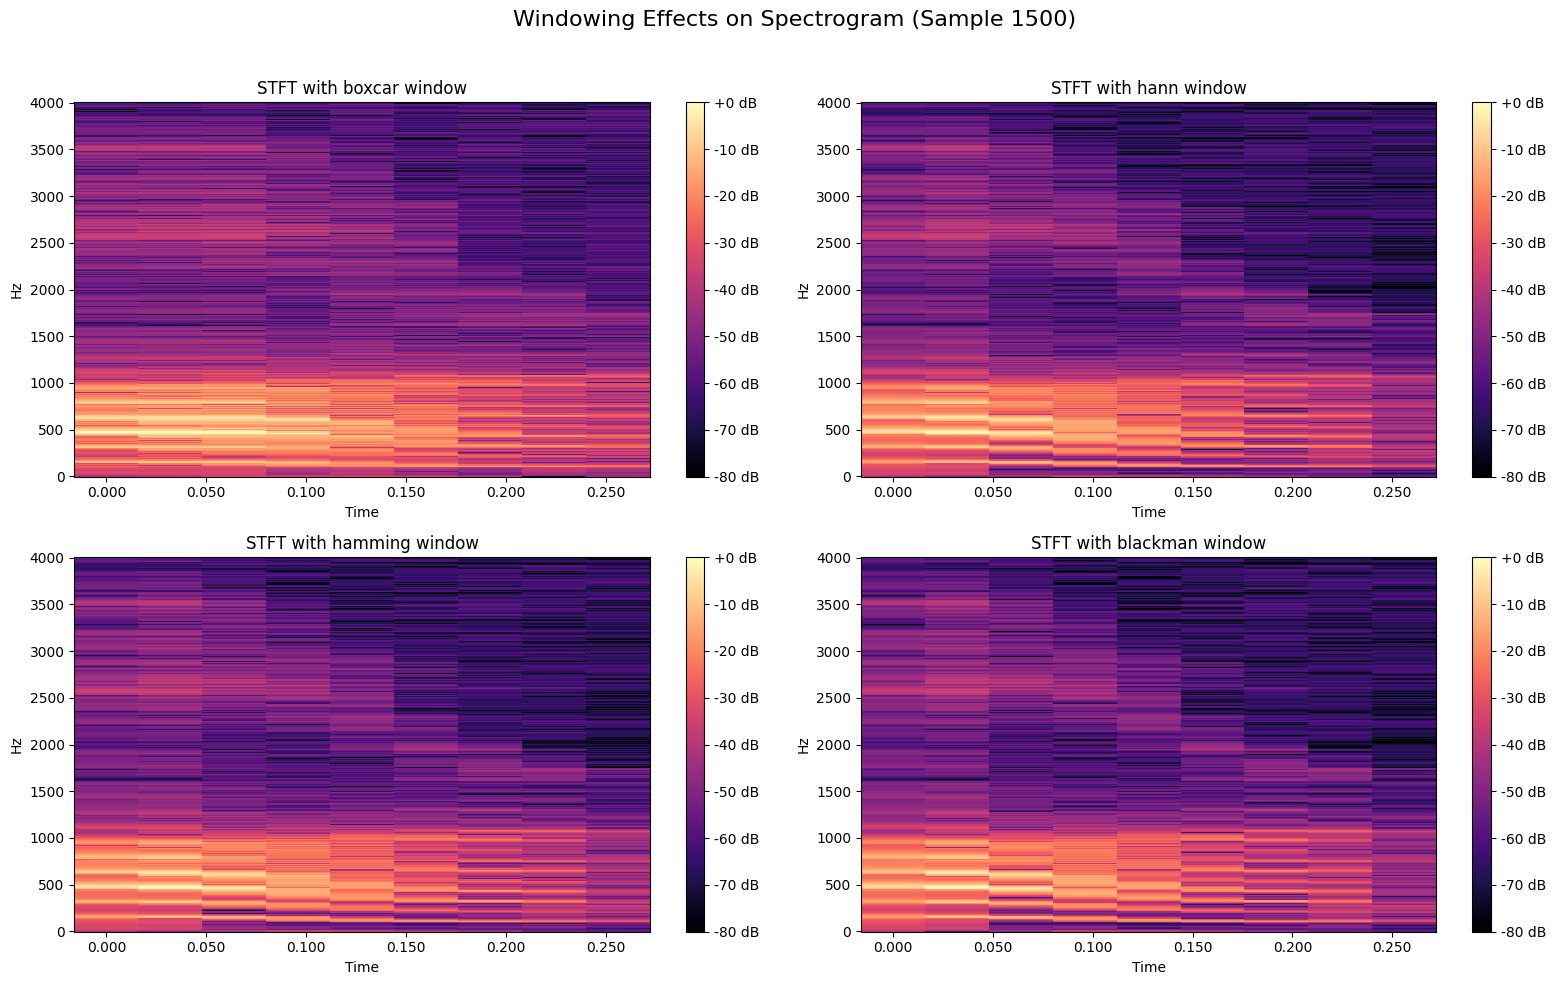

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Pick one sample
y = audio_signals[1500]
sr = 8000

# STFT parameters
n_fft = 1024
hop_length = 256
win_length = 1024
window_types = ['boxcar', 'hann', 'hamming', 'blackman']

plt.figure(figsize=(16, 10))

# Plot STFTs for each window
for i, wtype in enumerate(window_types):
    # Compute STFT
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=wtype)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Plot
    plt.subplot(2, 2, i+1)
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.title(f"STFT with {wtype} window")
    plt.colorbar(format='%+2.0f dB')

plt.suptitle("Windowing Effects on Spectrogram (Sample 1500)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Estimated formants (Hz): [np.float32(516.64886), np.float32(869.9388), np.float32(1143.8436)]


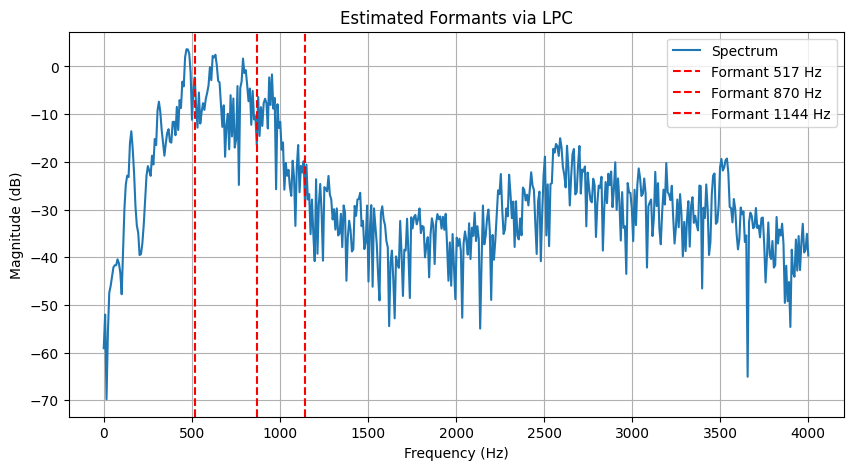

In [11]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# Use a sample signal
signal = audio_signals[1500]
fs = 8000

# Pre-emphasis filter to balance high frequencies
pre_emph = np.append(signal[0], signal[1:] - 0.97 * signal[:-1])

# LPC analysis (order 12 is common for speech)
lpc_order = 12
lpc_coeffs = librosa.lpc(pre_emph, order=lpc_order)

# Find roots of the LPC polynomial
roots = np.roots(lpc_coeffs)
roots = [r for r in roots if np.imag(r) >= 0]  # keep positive frequencies

# Convert to frequencies
angles = np.angle(roots)
formant_freqs = sorted(angles * (fs / (2 * np.pi)))

# Print the first 3 formants
formants = formant_freqs[:3]
print("Estimated formants (Hz):", formants)

# Plot the spectrum
w, h = np.linspace(0, np.pi, 512, endpoint=False), np.fft.fft(pre_emph, 1024)[:512]
freqs = np.linspace(0, fs / 2, len(w))

plt.figure(figsize=(10, 5))
plt.plot(freqs, 20 * np.log10(np.abs(h)), label='Spectrum')
for f in formants:
    plt.axvline(x=f, color='r', linestyle='--', label=f'Formant {round(f)} Hz')
plt.title("Estimated Formants via LPC")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid(True)
plt.show()
